## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Load and inspect the data
df = pd.read_csv('/content/Illinois_10_years_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969937 entries, 0 to 2969936
Data columns (total 31 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Year                              int64  
 1   Quarter                           int64  
 2   Month                             int64  
 3   Day_of_Month                      float64
 4   Day_of_Week                       float64
 5   Operating_Carrier_Code            object 
 6   Tail_Number                       object 
 7   Origin_Airport_ID                 float64
 8   Origin_Airport_Code               object 
 9   Origin_State_Name                 object 
 10  Destination_Airport_Code          object 
 11  Destination_State_Name            object 
 12  Scheduled_Departure_Time          float64
 13  Departure_Delay_Minutes           float64
 14  Taxi_Out_Time_Minutes             float64
 15  Flight_Distance_Miles             float64
 16  Departure_Datetime                ob

## Process predictors

In [3]:
# Convert integer features to int32
int_columns = [
    'Year',
    'Quarter',
    'Month',
    'Day_of_Month',
    'Day_of_Week',
    'Scheduled_Departure_Time',
    'Scheduled_Departure_Time_Minutes',
    'Target'
]

for col in int_columns:
    df[col] = df[col].astype(np.int32)

# Convert continuous numeric features to float32
float_columns = [
    'Departure_Delay_Minutes',
    'Taxi_Out_Time_Minutes',
    'Flight_Distance_Miles',
    'Air_Temperature_Fahrenheit',
    'Dew_Point_Temperature_Fahrenheit',
    'Relative_Humidity_Percent',
    'Wind_Direction_Degrees',
    'Wind_Speed_Knots',
    'Hourly_Precipitation_Inches',
    'Pressure_Altimeter_Inches',
    'Sea_Level_Pressure_Millibar',
    'Visibility_Miles',
    'Sky_Level_1_Altitude_Feet',
    'Apparent_Temperature_Fahrenheit',

]

for col in float_columns:
    df[col] = df[col].astype(np.float32)

# Convert categorical features to 'category' dtype
categorical_columns = [
    'Operating_Carrier_Code',
    'Tail_Number',
    'Origin_Airport_ID',
    'Origin_Airport_Code',
    'Origin_State_Name',
    'Destination_Airport_Code',
    'Destination_State_Name',
    'Sky_Cover_Level_1'
]

for col in categorical_columns:
    df[col] = df[col].astype('category')

In [4]:
df = df.drop([ 'Origin_State_Name','Departure_Datetime','Departure_Delay_Minutes','Taxi_Out_Time_Minutes'], axis=1)

In [5]:
df1= df[df['Month'] == 1]

In [6]:
categorical_columns = [
    'Operating_Carrier_Code',
    'Tail_Number',
    'Origin_Airport_ID',
    'Origin_Airport_Code',
    'Destination_Airport_Code',
    'Destination_State_Name',
    'Sky_Cover_Level_1'
]
#df1 = pd.get_dummies(df1, columns=categorical_columns)

In [7]:
df1 = df1.sample(frac=0.75, random_state=303).reset_index(drop=True)

In [8]:
label_encoders = {}
for col in df1.select_dtypes(include='category').columns:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col])
    label_encoders[col] = le

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180822 entries, 0 to 180821
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Year                              180822 non-null  int32  
 1   Quarter                           180822 non-null  int32  
 2   Month                             180822 non-null  int32  
 3   Day_of_Month                      180822 non-null  int32  
 4   Day_of_Week                       180822 non-null  int32  
 5   Operating_Carrier_Code            180822 non-null  int64  
 6   Tail_Number                       180822 non-null  int64  
 7   Origin_Airport_ID                 180822 non-null  int64  
 8   Origin_Airport_Code               180822 non-null  int64  
 9   Destination_Airport_Code          180822 non-null  int64  
 10  Destination_State_Name            180822 non-null  int64  
 11  Scheduled_Departure_Time          180822 non-null  i

## Split data into training, testing, and validation sets

In [10]:
# Define the years for each dataset
train_years = [2014, 2015, 2016, 2017, 2018, 2019]
val_years = [2020, 2021, 2022]
test_years = [2023, 2024]

# Ensure the 'Year' column is of integer type
df1['Year'] = df1['Year'].astype(int)

# Create the training set
train_df = df1[df1['Year'].isin(train_years)].reset_index(drop=True)

# Create the validation set
val_df = df1[df1['Year'].isin(val_years)].reset_index(drop=True)

# Create the test set
test_df = df1[df1['Year'].isin(test_years)].reset_index(drop=True)

x_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']
x_val = val_df.drop('Target', axis=1)
y_val = val_df['Target']
x_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

## Use SMOTE to balance dataset

In [11]:
smote = SMOTE(random_state = 303)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [12]:
print(y_train_resampled.value_counts())

Target
0    86383
1    86383
Name: count, dtype: int64


# Full dataset: Baseline

### Training set results

In [13]:
# Intercept-only logistic regression
# Ensure training data has no features (e.g., single column of zeros)
x_train_resampled_intercept = np.zeros((len(y_train_resampled), 1))  # No features
model = LogisticRegression(fit_intercept=True, solver='liblinear')
model.fit(x_train_resampled_intercept, y_train_resampled)

# Predictions and evaluation on the original data
# Transform original data to match intercept-only model
x_train_intercept = np.zeros((len(y_train), 1))  # Match training data structure
y_pred0 = model.predict(x_train_intercept)

# Print evaluation metrics
print("Accuracy (Intercept-Only Baseline):", accuracy_score(y_train, y_pred0))
print("Precision:", precision_score(y_train, y_pred0, pos_label=1))
print("Recall:", recall_score(y_train, y_pred0, pos_label=1))
print("F1 Score:", f1_score(y_train, y_pred0, pos_label=1))
print("Classification Report:\n", classification_report(y_train, y_pred0))

Accuracy (Intercept-Only Baseline): 0.7265425245592787
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84     86383
           1       0.00      0.00      0.00     32513

    accuracy                           0.73    118896
   macro avg       0.36      0.50      0.42    118896
weighted avg       0.53      0.73      0.61    118896



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


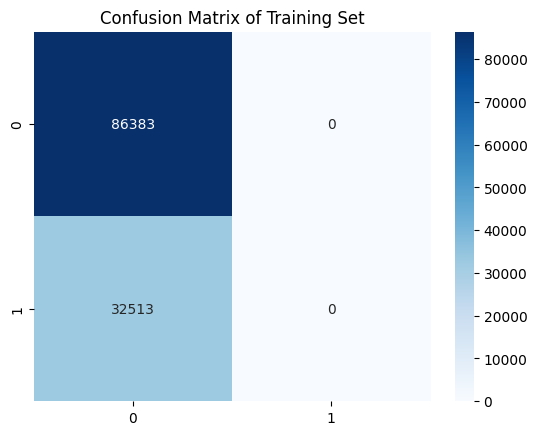

In [14]:
sns.heatmap(confusion_matrix(y_train, y_pred0), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Training Set")
plt.show()

### Validation set results

In [15]:
# Predict and evaluate
x_val_intercept = np.zeros((len(x_val), 1))
y_pred = model.predict(x_val_intercept)
print("Accuracy (Intercept-Only Baseline):", accuracy_score(y_val, y_pred))

precision = precision_score(y_val, y_pred, pos_label = 1)
recall = recall_score(y_val, y_pred, pos_label = 1)
f1 = f1_score(y_val, y_pred, pos_label = 1)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy (Intercept-Only Baseline): 0.8190940766550523
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Logistic Regression Accuracy: 0.8190940766550523
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     35262
           1       0.00      0.00      0.00      7788

    accuracy                           0.82     43050
   macro avg       0.41      0.50      0.45     43050
weighted avg       0.67      0.82      0.74     43050



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

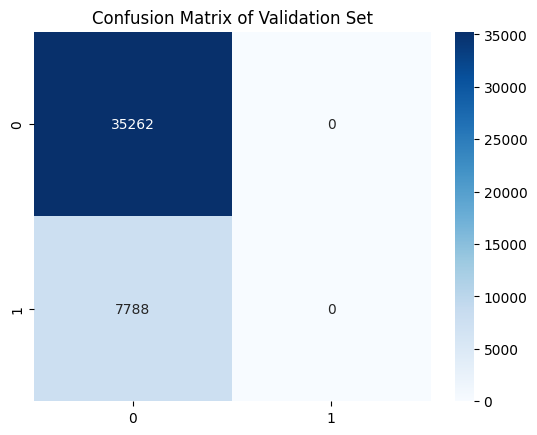

In [16]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Validation Set")
plt.show()

### Testing set results

In [17]:
# Predict and evaluate
x_test_intercept = np.zeros((len(x_test), 1))
y_pred2 = model.predict(x_test_intercept)

print("Accuracy (Intercept-Only Baseline):", accuracy_score(y_test, y_pred2))

precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Accuracy (Intercept-Only Baseline): 0.7198559016740835
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Logistic Regression Accuracy: 0.7198559016740835
Classification Report:
               precision    recall  f1-score   support

           0       0.72      1.00      0.84     13588
           1       0.00      0.00      0.00      5288

    accuracy                           0.72     18876
   macro avg       0.36      0.50      0.42     18876
weighted avg       0.52      0.72      0.60     18876



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

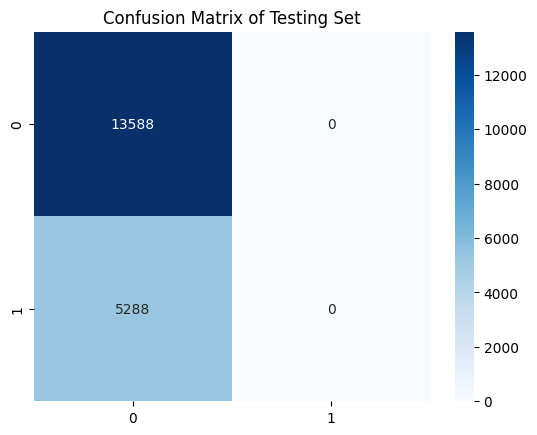

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Testing Set")
plt.show()

### ROC curve

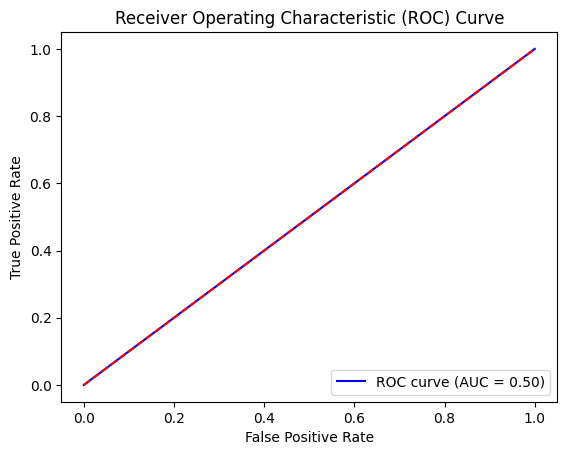

In [19]:
# Get predicted probabilities for the positive class
y_test_proba = model.predict_proba(x_test_intercept)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Compute AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plot the ROC curve
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Full dataset: Full Logistic Regression

In [20]:
model_LR = LogisticRegression(max_iter=500)
model_LR.fit(x_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

### Training set results

Logistic Regression Accuracy: 0.652494617144395
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.65      0.73     86383
           1       0.41      0.66      0.51     32513

    accuracy                           0.65    118896
   macro avg       0.62      0.65      0.62    118896
weighted avg       0.72      0.65      0.67    118896



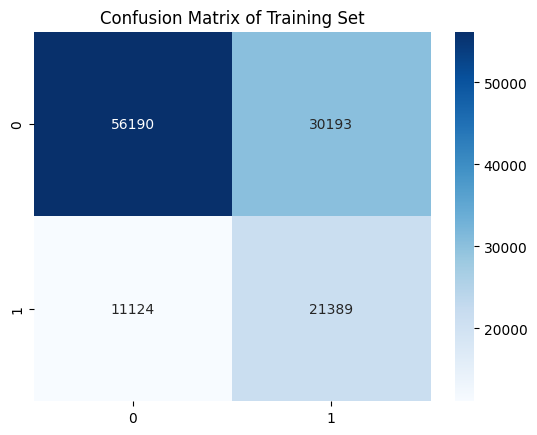

In [21]:
y_pred5 = model_LR.predict(x_train)
print("Logistic Regression Accuracy:", accuracy_score(y_train, y_pred5))
print("Classification Report:\n", classification_report(y_train, y_pred5))

sns.heatmap(confusion_matrix(y_train, y_pred5), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Training Set")
plt.show()

### Validation set results

Logistic Regression Accuracy: 0.6516144018583043
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.68      0.76     35262
           1       0.27      0.54      0.36      7788

    accuracy                           0.65     43050
   macro avg       0.57      0.61      0.56     43050
weighted avg       0.76      0.65      0.69     43050



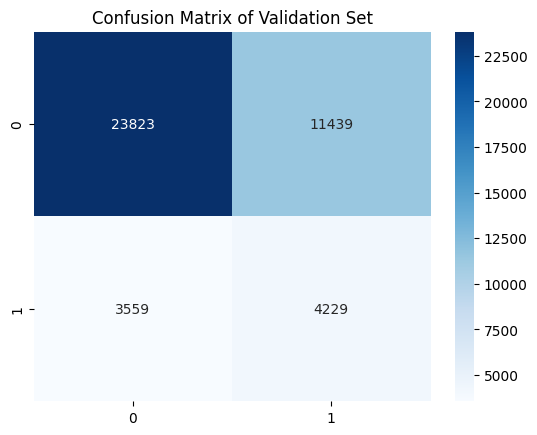

In [22]:
y_pred3 = model_LR.predict(x_val)
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred3))
print("Classification Report:\n", classification_report(y_val, y_pred3))

sns.heatmap(confusion_matrix(y_val, y_pred3), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Validation Set")
plt.show()

### Testing set results

Logistic Regression Accuracy: 0.6534753125662217
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.66      0.73     13588
           1       0.42      0.63      0.50      5288

    accuracy                           0.65     18876
   macro avg       0.62      0.65      0.62     18876
weighted avg       0.71      0.65      0.67     18876



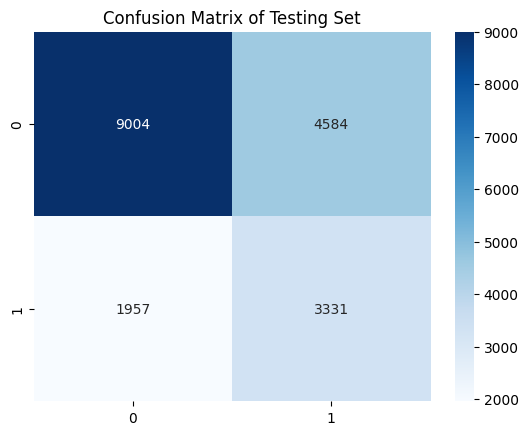

In [23]:
y_pred4 = model_LR.predict(x_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred4))
print("Classification Report:\n", classification_report(y_test, y_pred4))

sns.heatmap(confusion_matrix(y_test, y_pred4), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Testing Set")
plt.show()

### Feature importance

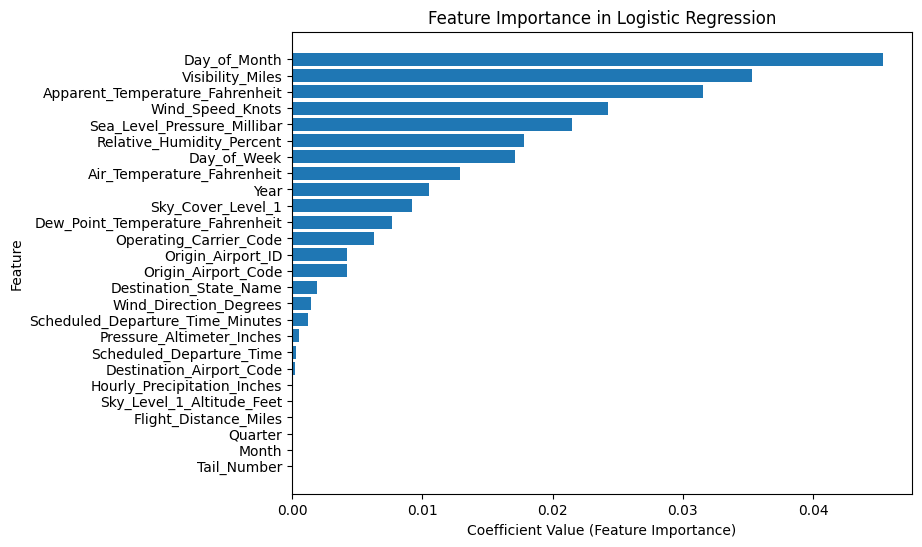

In [24]:
# Get feature names and coefficients
feature_names = x_train_resampled.columns  # Adjust for your data structure
coefficients = model_LR.coef_[0]  # Coefficients for the first class (binary classification)

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Coefficient Value (Feature Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # Invert axis for better readability
plt.show()

### ROC curve

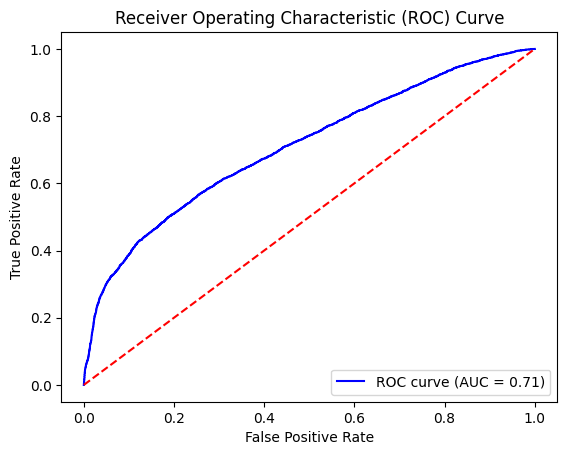

In [25]:
# Assuming model, X_test, and y_test are already defined
y_scores = model_LR.predict_proba(x_test)[:, 1]  # Probability of positive class

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Full dataset: Random Forest

In [26]:
model_rf = RandomForestClassifier(random_state=303)

In [27]:
model_rf.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=303)

### Training set results

Random Forest Accuracy: 0.9999915892881174
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     86383
           1       1.00      1.00      1.00     32513

    accuracy                           1.00    118896
   macro avg       1.00      1.00      1.00    118896
weighted avg       1.00      1.00      1.00    118896



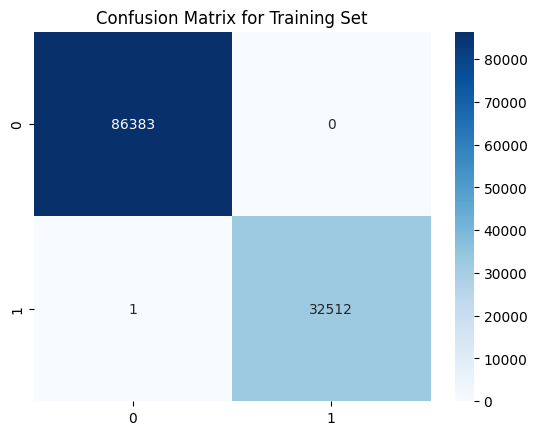

In [28]:
y_pred_rf3 = model_rf.predict(x_train)
print("Random Forest Accuracy:", accuracy_score(y_train, y_pred_rf3))
print("Classification Report:\n", classification_report(y_train, y_pred_rf3))
sns.heatmap(confusion_matrix(y_train, y_pred_rf3), cmap= "Blues", annot=True, fmt='d')
plt.title('Confusion Matrix for Training Set')
plt.show()

### Validation set results

Random Forest Accuracy: 0.48283391405342624
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.44      0.58     35262
           1       0.21      0.69      0.32      7788

    accuracy                           0.48     43050
   macro avg       0.54      0.56      0.45     43050
weighted avg       0.75      0.48      0.53     43050



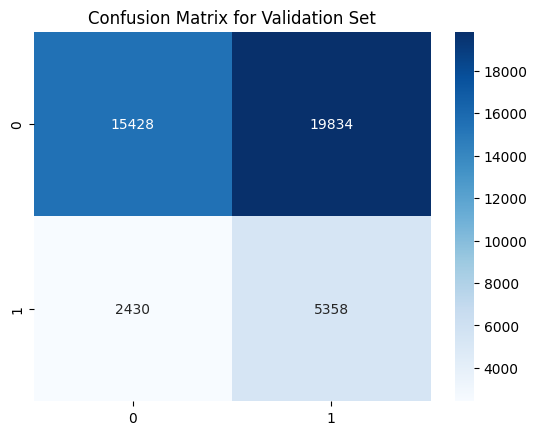

In [29]:
y_pred_rf = model_rf.predict(x_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_pred_rf))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), cmap= "Blues", annot=True, fmt='d')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Testing set results

Random Forest Accuracy: 0.5519707565162111
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.48      0.61     13588
           1       0.36      0.74      0.48      5288

    accuracy                           0.55     18876
   macro avg       0.59      0.61      0.54     18876
weighted avg       0.70      0.55      0.57     18876



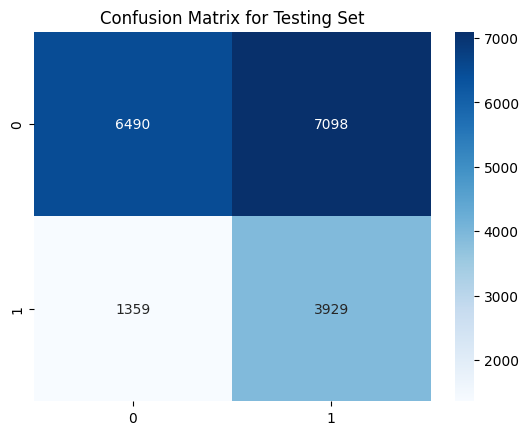

In [30]:
y_pred_rf2 = model_rf.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf2))
print("Classification Report:\n", classification_report(y_test, y_pred_rf2))
sns.heatmap(confusion_matrix(y_test, y_pred_rf2), cmap= "Blues", annot=True, fmt='d')
plt.title('Confusion Matrix for Testing Set')
plt.show()

### ROC Curve

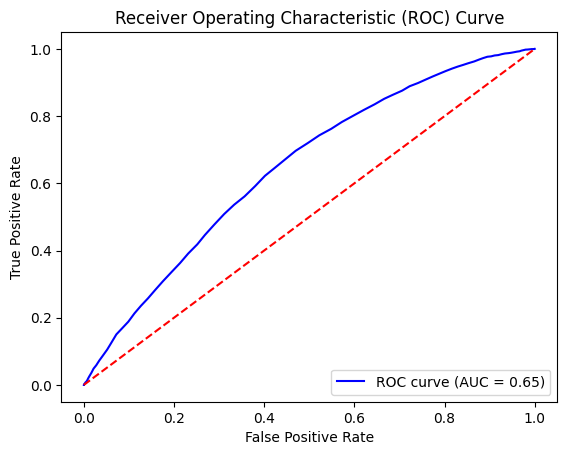

In [31]:
# Assuming model, X_test, and y_test are already defined
y_scores = model_rf.predict_proba(x_test)[:, 1]  # Probability of positive class

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Feature importance

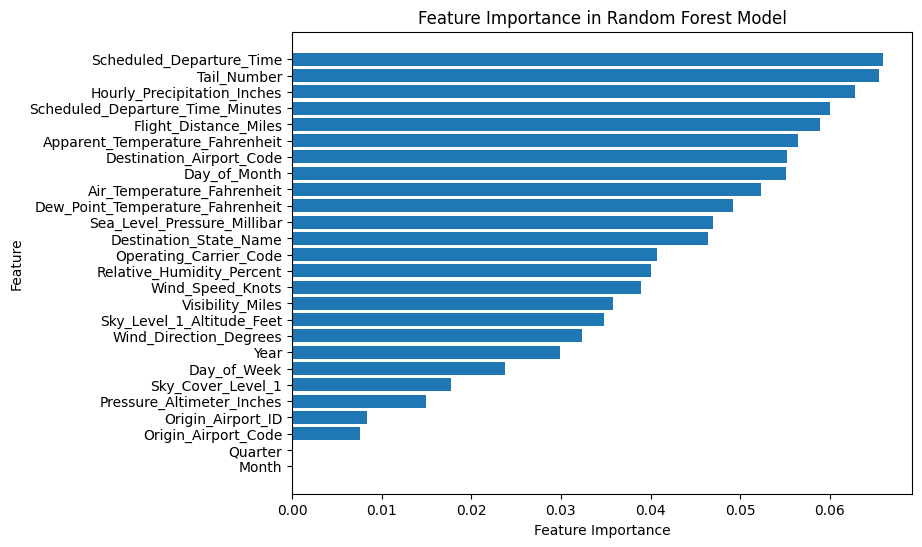

In [32]:
# Get feature importance
feature_importance = model_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train_resampled.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Flight-only dataset

In [33]:
flights_columns = [
    "Quarter", "Month", "Day_of_Month", "Day_of_Week", "Operating_Carrier_Code", "Tail_Number",
    "Origin_Airport_ID", "Origin_Airport_Code", "Destination_Airport_Code",
    "Destination_State_Name", "Scheduled_Departure_Time",
    "Flight_Distance_Miles", "Scheduled_Departure_Time_Minutes"
]

In [34]:
x_train = train_df[flights_columns]
y_train = train_df['Target']
x_val = val_df[flights_columns]
y_val = val_df['Target']
x_test = test_df[flights_columns]
y_test = test_df['Target']

In [35]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118896 entries, 0 to 118895
Data columns (total 13 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Quarter                           118896 non-null  int32  
 1   Month                             118896 non-null  int32  
 2   Day_of_Month                      118896 non-null  int32  
 3   Day_of_Week                       118896 non-null  int32  
 4   Operating_Carrier_Code            118896 non-null  int64  
 5   Tail_Number                       118896 non-null  int64  
 6   Origin_Airport_ID                 118896 non-null  int64  
 7   Origin_Airport_Code               118896 non-null  int64  
 8   Destination_Airport_Code          118896 non-null  int64  
 9   Destination_State_Name            118896 non-null  int64  
 10  Scheduled_Departure_Time          118896 non-null  int32  
 11  Flight_Distance_Miles             118896 non-null  f

In [36]:
smote = SMOTE(random_state = 303)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Flight data: Full Logistic Regression[link text](https://)

In [37]:
model_LR = LogisticRegression(max_iter=500)
model_LR.fit(x_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

### Training set results

Logistic Regression Accuracy: 0.6037881846319473
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.61      0.69     86383
           1       0.36      0.58      0.45     32513

    accuracy                           0.60    118896
   macro avg       0.58      0.60      0.57    118896
weighted avg       0.68      0.60      0.62    118896



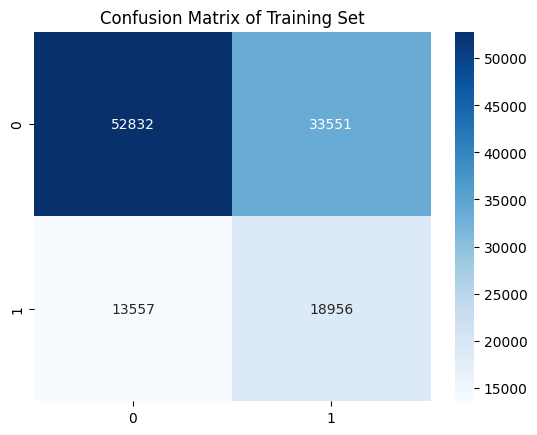

In [38]:
y_pred5 = model_LR.predict(x_train)
print("Logistic Regression Accuracy:", accuracy_score(y_train, y_pred5))
print("Classification Report:\n", classification_report(y_train, y_pred5))

sns.heatmap(confusion_matrix(y_train, y_pred5), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Training Set")
plt.show()

### Validation set results

Logistic Regression Accuracy: 0.5283623693379791
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.53      0.65     35262
           1       0.20      0.52      0.29      7788

    accuracy                           0.53     43050
   macro avg       0.52      0.53      0.47     43050
weighted avg       0.72      0.53      0.58     43050



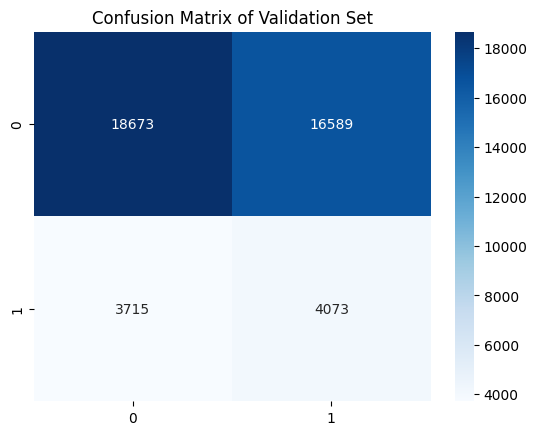

In [39]:
y_pred3 = model_LR.predict(x_val)
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred3))
print("Classification Report:\n", classification_report(y_val, y_pred3))

sns.heatmap(confusion_matrix(y_val, y_pred3), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Validation Set")
plt.show()

### Testing set results

Logistic Regression Accuracy: 0.5582220809493537
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.60      0.66     13588
           1       0.31      0.46      0.37      5288

    accuracy                           0.56     18876
   macro avg       0.52      0.53      0.51     18876
weighted avg       0.62      0.56      0.58     18876



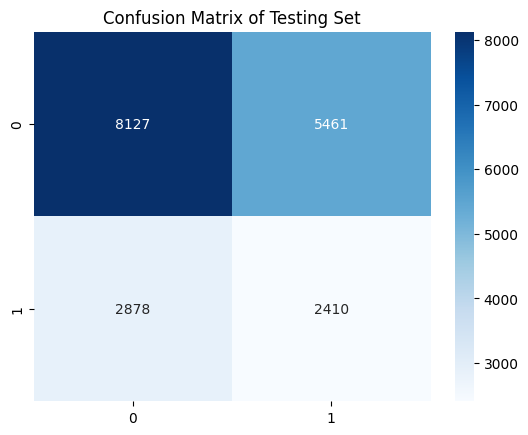

In [40]:
y_pred4 = model_LR.predict(x_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred4))
print("Classification Report:\n", classification_report(y_test, y_pred4))

sns.heatmap(confusion_matrix(y_test, y_pred4), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Testing Set")
plt.show()

### Feature importance

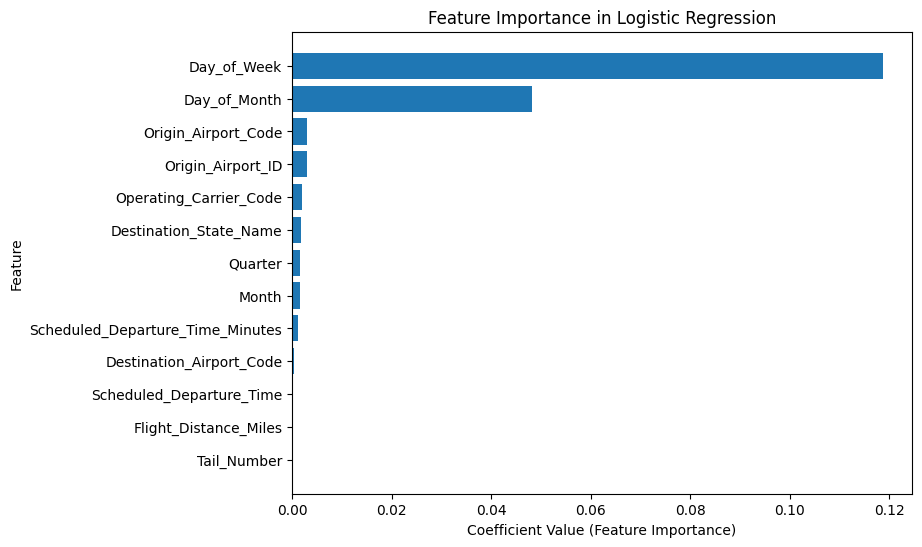

In [41]:
feature_names = x_train_resampled.columns
coefficients = model_LR.coef_[0]


feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Coefficient Value (Feature Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

### ROC curve

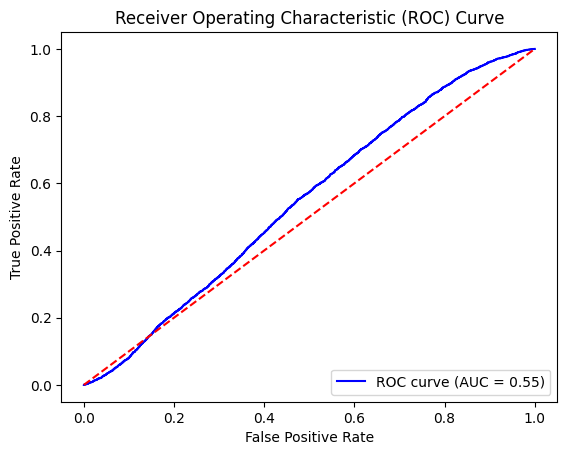

In [42]:
y_scores = model_LR.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Flight data: Random Forest

In [43]:
model_rf = RandomForestClassifier(random_state=303)
model_rf.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=303)

### Training set results

Random Forest Accuracy: 0.9999831785762346
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     86383
           1       1.00      1.00      1.00     32513

    accuracy                           1.00    118896
   macro avg       1.00      1.00      1.00    118896
weighted avg       1.00      1.00      1.00    118896



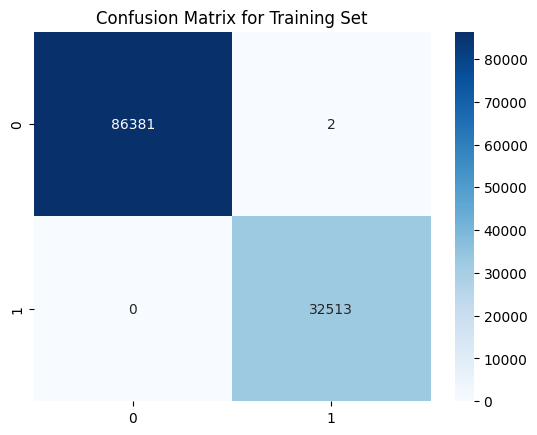

In [44]:
y_pred_rf3 = model_rf.predict(x_train)
print("Random Forest Accuracy:", accuracy_score(y_train, y_pred_rf3))
print("Classification Report:\n", classification_report(y_train, y_pred_rf3))
sns.heatmap(confusion_matrix(y_train, y_pred_rf3), cmap= "Blues", annot=True, fmt='d')
plt.title('Confusion Matrix for Training Set')
plt.show()

### Validation set results

Random Forest Accuracy: 0.6335656213704994
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76     35262
           1       0.20      0.33      0.25      7788

    accuracy                           0.63     43050
   macro avg       0.51      0.52      0.50     43050
weighted avg       0.71      0.63      0.67     43050



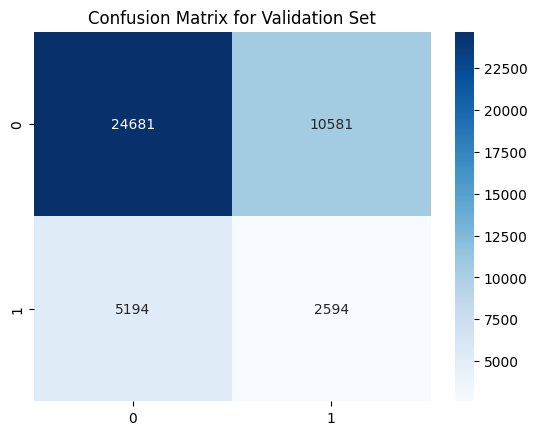

In [45]:
y_pred_rf = model_rf.predict(x_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_pred_rf))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), cmap= "Blues", annot=True, fmt='d')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Testing set results

Random Forest Accuracy: 0.6406018224200042
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.76     13588
           1       0.34      0.30      0.32      5288

    accuracy                           0.64     18876
   macro avg       0.54      0.54      0.54     18876
weighted avg       0.63      0.64      0.63     18876



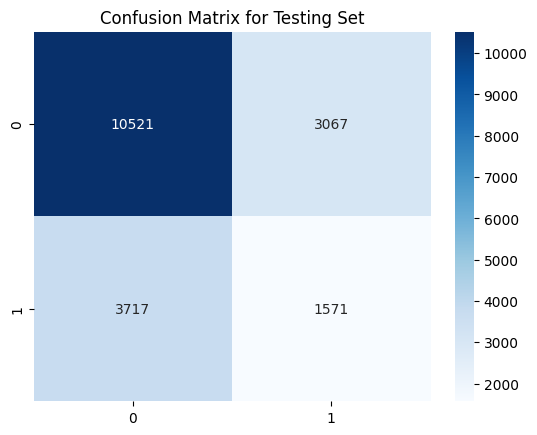

In [46]:
y_pred_rf2 = model_rf.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf2))
print("Classification Report:\n", classification_report(y_test, y_pred_rf2))
sns.heatmap(confusion_matrix(y_test, y_pred_rf2), cmap= "Blues", annot=True, fmt='d')
plt.title('Confusion Matrix for Testing Set')
plt.show()

### ROC curve

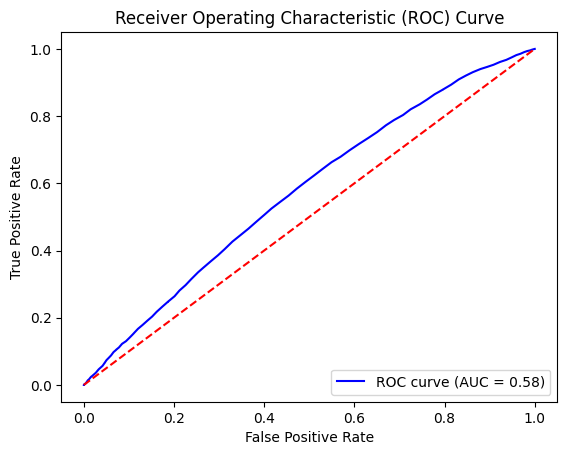

In [47]:
# Assuming model, X_test, and y_test are already defined
y_scores = model_rf.predict_proba(x_test)[:, 1]  # Probability of positive class

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Feature importance

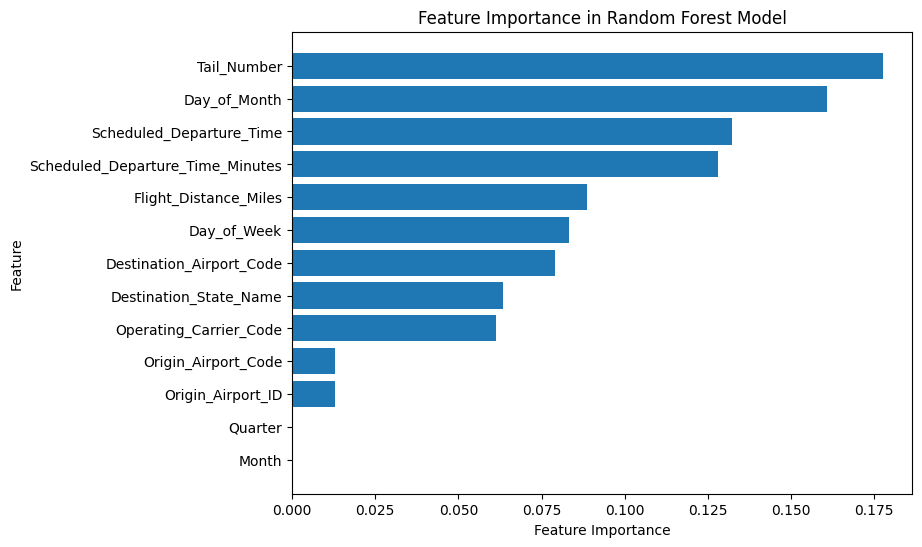

In [48]:
# Get feature importance
feature_importance = model_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train_resampled.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Weather-only dataset

In [63]:
weather_columns = [
    "Air_Temperature_Fahrenheit", "Dew_Point_Temperature_Fahrenheit",
    "Relative_Humidity_Percent", "Wind_Direction_Degrees", "Wind_Speed_Knots",
    "Hourly_Precipitation_Inches", "Pressure_Altimeter_Inches",
    "Sea_Level_Pressure_Millibar", "Visibility_Miles", "Sky_Cover_Level_1",
    "Sky_Level_1_Altitude_Feet", "Apparent_Temperature_Fahrenheit"
]

x_train = train_df[weather_columns]
y_train = train_df['Target']
x_val = val_df[weather_columns]
y_val = val_df['Target']
x_test = test_df[weather_columns]
y_test = test_df['Target']


x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118896 entries, 0 to 118895
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Air_Temperature_Fahrenheit        118896 non-null  float32
 1   Dew_Point_Temperature_Fahrenheit  118896 non-null  float32
 2   Relative_Humidity_Percent         118896 non-null  float32
 3   Wind_Direction_Degrees            118896 non-null  float32
 4   Wind_Speed_Knots                  118896 non-null  float32
 5   Hourly_Precipitation_Inches       118896 non-null  float32
 6   Pressure_Altimeter_Inches         118896 non-null  float32
 7   Sea_Level_Pressure_Millibar       118896 non-null  float32
 8   Visibility_Miles                  118896 non-null  float32
 9   Sky_Cover_Level_1                 118896 non-null  int64  
 10  Sky_Level_1_Altitude_Feet         118896 non-null  float32
 11  Apparent_Temperature_Fahrenheit   118896 non-null  f

In [64]:
smote = SMOTE(random_state = 303)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Weather only: Full LR

In [65]:
model_LR = LogisticRegression(max_iter=500)
model_LR.fit(x_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

### Training set results

Logistic Regression Accuracy: 0.6451688870946037
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.66      0.73     86383
           1       0.40      0.61      0.49     32513

    accuracy                           0.65    118896
   macro avg       0.61      0.64      0.61    118896
weighted avg       0.70      0.65      0.66    118896



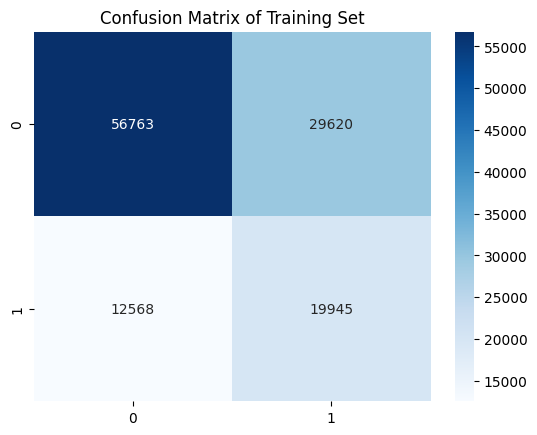

In [66]:
y_pred5 = model_LR.predict(x_train)
print("Logistic Regression Accuracy:", accuracy_score(y_train, y_pred5))
print("Classification Report:\n", classification_report(y_train, y_pred5))

sns.heatmap(confusion_matrix(y_train, y_pred5), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Training Set")
plt.show()

### Validation set results

Logistic Regression Accuracy: 0.6400232288037166
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.75     35262
           1       0.25      0.50      0.34      7788

    accuracy                           0.64     43050
   macro avg       0.56      0.59      0.54     43050
weighted avg       0.75      0.64      0.68     43050



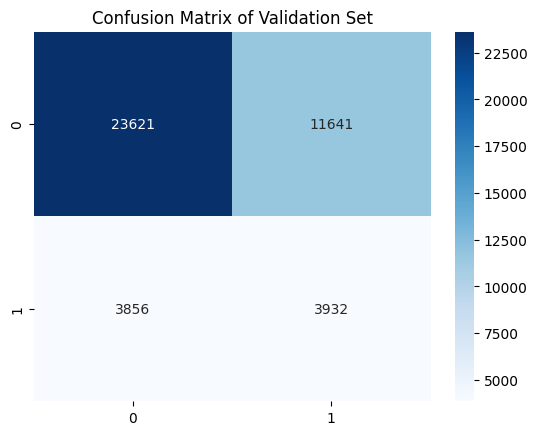

In [67]:
y_pred3 = model_LR.predict(x_val)
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred3))
print("Classification Report:\n", classification_report(y_val, y_pred3))

sns.heatmap(confusion_matrix(y_val, y_pred3), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Validation Set")
plt.show()

### Testing set results

Logistic Regression Accuracy: 0.6442572578936215
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.64      0.72     13588
           1       0.41      0.65      0.51      5288

    accuracy                           0.64     18876
   macro avg       0.62      0.65      0.61     18876
weighted avg       0.71      0.64      0.66     18876



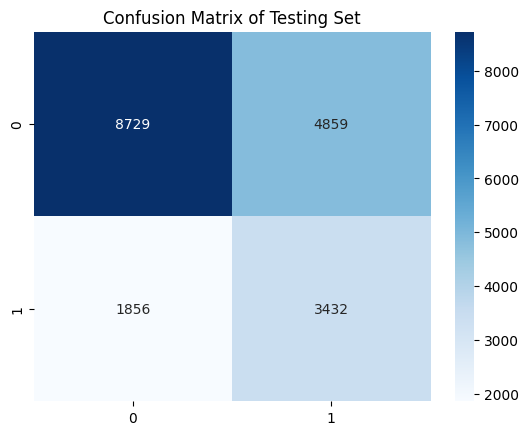

In [68]:
y_pred4 = model_LR.predict(x_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred4))
print("Classification Report:\n", classification_report(y_test, y_pred4))

sns.heatmap(confusion_matrix(y_test, y_pred4), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix of Testing Set")
plt.show()

### Feature importance

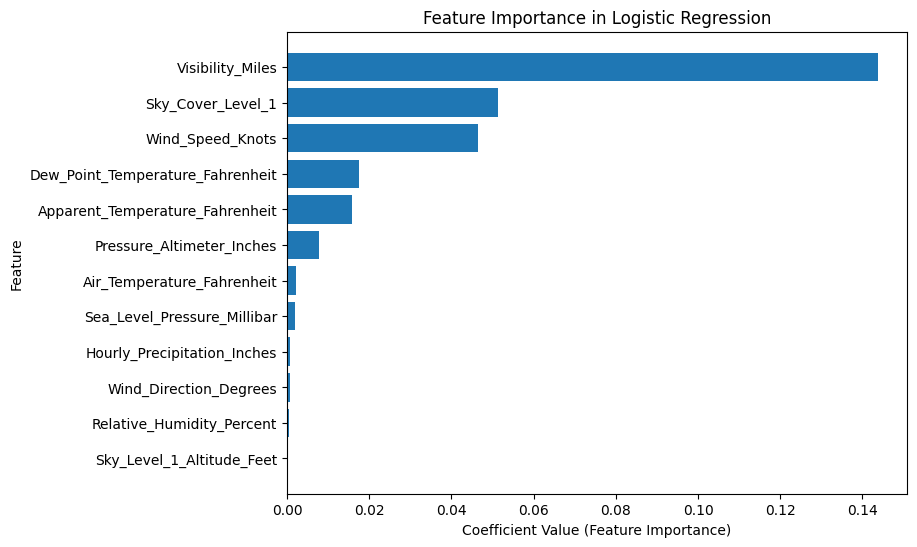

In [69]:
feature_names = x_train_resampled.columns
coefficients = model_LR.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Coefficient Value (Feature Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

ROC curve

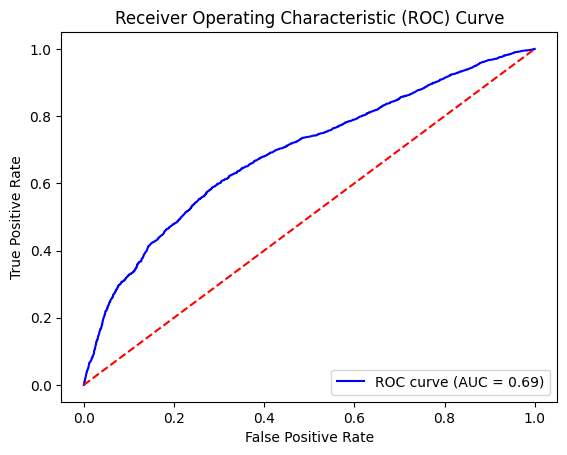

In [70]:
y_scores = model_LR.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Weather only: Random Forest

In [71]:
model_rf = RandomForestClassifier(random_state=303)
model_rf.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=303)

### Training set results

Random Forest Accuracy: 0.8028108599111828
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86     86383
           1       0.63      0.67      0.65     32513

    accuracy                           0.80    118896
   macro avg       0.75      0.76      0.76    118896
weighted avg       0.81      0.80      0.80    118896



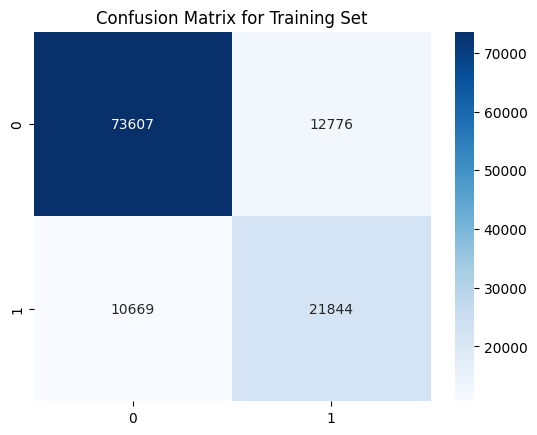

In [72]:
y_pred_rf3 = model_rf.predict(x_train)
print("Random Forest Accuracy:", accuracy_score(y_train, y_pred_rf3))
print("Classification Report:\n", classification_report(y_train, y_pred_rf3))
sns.heatmap(confusion_matrix(y_train, y_pred_rf3), cmap= "Blues", annot=True, fmt='d')
plt.title('Confusion Matrix for Training Set')
plt.show()

### Validation set results

Random Forest Accuracy: 0.5696399535423926
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.58      0.69     35262
           1       0.21      0.52      0.30      7788

    accuracy                           0.57     43050
   macro avg       0.53      0.55      0.50     43050
weighted avg       0.73      0.57      0.62     43050



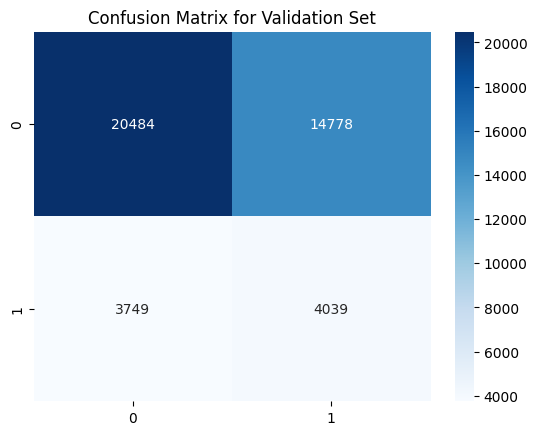

In [73]:
y_pred_rf = model_rf.predict(x_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Classification Report:\n", classification_report(y_val, y_pred_rf))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), cmap= "Blues", annot=True, fmt='d')
plt.title('Confusion Matrix for Validation Set')
plt.show()

### Testing set results

Random Forest Accuracy: 0.5653740199194744
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.55      0.65     13588
           1       0.34      0.60      0.44      5288

    accuracy                           0.57     18876
   macro avg       0.56      0.58      0.54     18876
weighted avg       0.66      0.57      0.59     18876



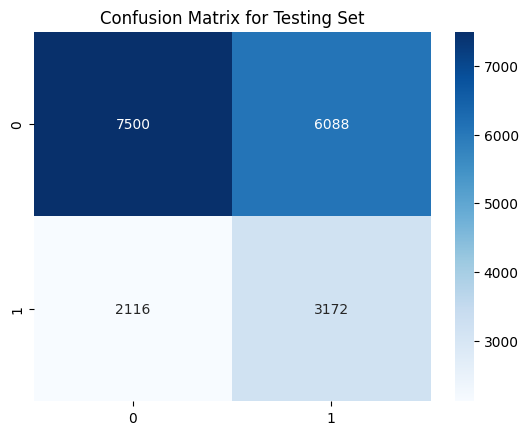

In [74]:
y_pred_rf2 = model_rf.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf2))
print("Classification Report:\n", classification_report(y_test, y_pred_rf2))
sns.heatmap(confusion_matrix(y_test, y_pred_rf2), cmap= "Blues", annot=True, fmt='d')
plt.title('Confusion Matrix for Testing Set')
plt.show()

### ROC curve

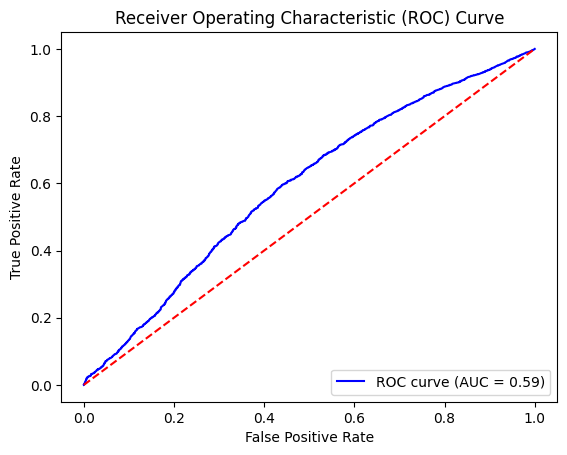

In [75]:
y_scores = model_rf.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Feature importance

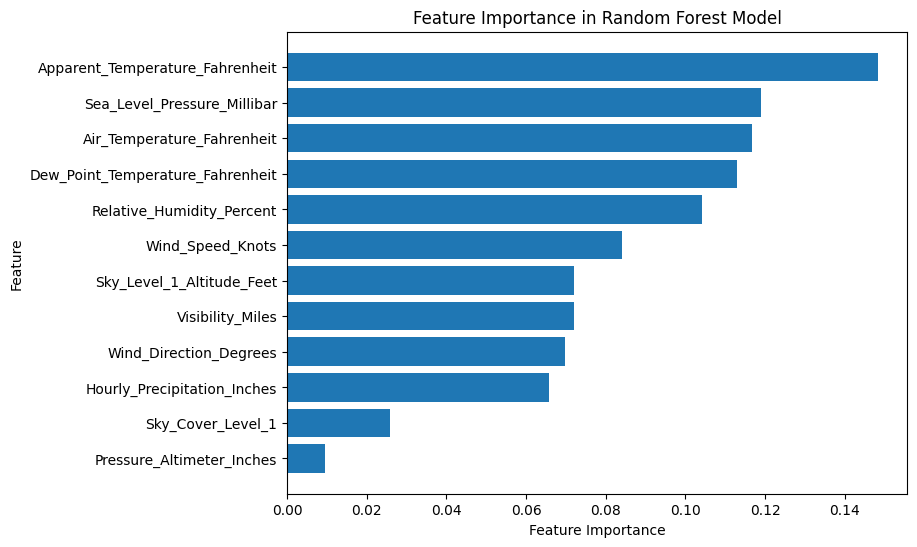

In [76]:
feature_importance = model_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train_resampled.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()